In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def cm2inch(value):
    return value/2.54

In [3]:
# plotsize_subplots = (cm2inch(19),cm2inch(3.5))
# plotsize_subplots = (cm2inch(19),cm2inch(9))
plotsize_subplots = (16,3)

fontsize_axis = 9
fontsize_labels = 9
fontsize_legends = 8

plt.rcParams.update({'figure.figsize': plotsize_subplots,
                     'axes.titlesize': fontsize_labels,
                     'axes.labelsize': fontsize_labels,
                     'ytick.labelsize': 'small'})

# Functions

In [4]:
def calculate_T_conn_and_memory(df):
    """Calculate T_conn and memory_per_vp"""
    
    # For MAM, T_conns is divided into T_network_global and T_connect:
    if 'T_conns_min' not in list(df) and 'T_network_global_min' in list(df): 
        df['T_conns_min'] = df['T_network_global_min'] + df['T_connect_min']
        df['T_conns_max'] = df['T_network_global_max'] + df['T_connect_max']
    
    df['T_bld_xn'] = df['T_conns_min'] + df['T_ini_max']
    df['T_bld_nx'] = df['T_conns_max'] + df['T_ini_min']
    df['Conn. Total']   = df[['T_bld_xn', 'T_bld_nx']].min(axis=1)
    df['Conn. Creation (min)'] = df['T_conns_min']
    df['Conn. Exchange (min)'] = df['T_ini_min']

    
    if 'NUM_VPS' not in list(df):
        df['N_VP'] = df['NUMBER_OF_NODES']*df['TASKS_PER_NODE']*df['THREADS_PER_TASK']
    else:
        df['N_VP'] = df['NUM_VPS']
    if np.isnan(df['VSize_sum']).all():  # Population model
        # Population model does not simulate, VSize_mem is therefore equal to VSize_ini_sum as this is the
        # end of the benchmark
        df['VSize_sum'] = df['VSize_ini_sum']
    if 'VSize_mem_sum' not in list(df) and 'VSize_nodes_sum' not in list(df):  # MAM
        df['VSize_mem_sum'] = df['VSize_net_sum']  # VSize_mem_sum is called VSize_net_sum for MAM
        df['VSize_nodes_sum'] = np.NaN  # MAM model does not have VSize_nodes_sum

    # Vi har MiB = 1024**2 B
    # Verdien vi får fra NEST er i KiB (http://www.nest-simulator.org/helpindex/sli/memory_thisjob.html)

    df['connections'] = ((df['VSize_mem_sum']-df['VSize_nodes_sum'])/df['N_VP'])*1024/1024**3
    df['ini'] = ((df['VSize_ini_sum']-df['VSize_mem_sum'])/df['N_VP'])*1024/1024**3
    df['other'] = (df['VSize_sum']/df['N_VP'])*1024/1024**3 - df['connections'] - df['ini']
    df['Memory per VP'] = (df['VSize_sum']/df['N_VP'])*1024/1024**3

    return df

In [5]:
def plot_compare(df, name, values=None, index=None, legend_loc='lower right', rot=45, one_row=True, logy=False,
                 color=None, plot_T_sim=True, plot_kind='bar', title=''):
    """Plot times for different cases"""
    
    if not values:
        values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per VP']
    if not index:
        index='N_VP'
    if plot_T_sim:
        df['Simulation time'] = df['T_sim']
        values.insert(3, 'Simulation time')
    df_p = pd.pivot_table(df, index=index, columns='Case', values=values)

    # Make subplots
    if one_row:
        fig, axes = plt.subplots(nrows=1, ncols=len(values))
        if len(values) == 1:
            axes = [axes]
                
        for indx, val_name in enumerate(values):
            df_p[val_name].plot(kind=plot_kind, ax = axes[indx], title=val_name, fontsize=fontsize_axis, rot=rot,
                                logy=logy, legend=False, color=color)
        axes[0].legend(fontsize=fontsize_legends, loc=legend_loc)
        
        plt.subplots_adjust(wspace=0.5)
    else:
        plotsize_subplots = (cm2inch(19),cm2inch(9))
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=plotsize_subplots)

        df_p['Conn. Creation (min)'].plot(kind='bar', ax = axes[0][0], title='Conn. Creation (min)',
                                          fontsize=fontsize_axis, rot=rot, legend=False)
        axes[0][0].legend(fontsize=fontsize_legends, loc=legend_loc)
        df_p['Conn. Exchange (min)'].plot(kind='bar', ax = axes[0][1], title='Conn. Exchange (min)',
                                          fontsize=fontsize_axis, rot=rot, legend=False)
        df_p['Conn. Total'].plot(kind='bar', ax = axes[1][0], title='Conn. Total', fontsize=fontsize_axis,
                                 rot=rot, legend=False)
        df_p['Memory per VP'].plot(kind='bar', ax = axes[1][1], title='Memory per VP', fontsize=fontsize_axis,
                                   rot=rot, legend=False)

        plt.subplots_adjust(wspace=0.5, hspace=0.7)

    # y-axis labels
    if 'Total Conn. Time per Conn.' in values:  
        axes[0].set_ylabel(r'Time [$\mu$s]')  # Not safe..
    else:
        if one_row:
            axes[0].set_ylabel('Time [s]')
        else:
            axes[0][0].set_ylabel('Time [s]')
            axes[1][0].set_ylabel('Time [s]')
    if 'Memory per VP' in values:
        # Assume memory is last entry in values
        if one_row:
            axes[len(values) - 1].set_ylabel('Memory [GiB]')
        else:
            axes[1][1].set_ylabel('Memory [GiB]')
    elif 'Memory per connection' in values:
        axes[len(values) - 1].set_ylabel('Memory [B]')

    # x-axis labels
    if one_row:
        for ax in axes:
            ax.set_xlabel(index)

    if title:
        fig.suptitle(title, y=1.2)
            
    fig = plt.gcf()
    fig.savefig(name, bbox_inches='tight')
    
    return df_p

# Benchmarks - Piz Daint

## HPC Benchmark - weak scaling

Conn. Creation (min)                                   \
Case 01/02/21 - caaf06324 22/01/21 - f1c0bcf43 NEST 2.20.1   
N_VP                                                         
36                  57.26                57.29       49.46   
72                  56.92                56.88       49.90   
144                 57.22                56.92       49.79   
288                 57.60                57.63       49.70   
576                 58.58                58.60       49.68   
1152                  NaN                  NaN       49.31   

     Conn. Exchange (min)                                   \
Case 01/02/21 - caaf06324 22/01/21 - f1c0bcf43 NEST 2.20.1   
N_VP                                                         
36                  80.12                78.20       52.03   
72                  80.42                81.79       53.56   
144                 81.16                82.00       58.56   
288                 85.57                83.44       62.60   
576                 90.36                89.22       73.80   
1152                  NaN                  NaN       84.42   

              Conn. Total                                   \
Case 01/02/21 - caaf06324 22/01/21 - f1c0bcf43 NEST 2.20.1   
N_VP                                                         
36                 143.96               144.72      105.12   
72                 149.78               151.06      108.32   
144                146.65               150.58      115.60   
288                154.77               152.47      119.43   
576                161.48               160.35      130.83   
1152                  NaN                  NaN      140.68   

            Memory per VP                                   \
Case 01/02/21 - caaf06324 22/01/21 - f1c0bcf43 NEST 2.20.1   
N_VP                                                         
36               2.885827             2.885013    2.815798   
72               2.894900             2.893679    2.819500   
144              2.978456             2.978131    2.905091   
288              2.984294             2.984884    2.910298   
576              3.083718             3.073098    3.062080   
1152                  NaN                  NaN    3.381250   

          Simulation time                                   
Case 01/02/21 - caaf06324 22/01/21 - f1c0bcf43 NEST 2.20.1  
N_VP                                                        
36                 205.20               203.26      194.38  
72                 210.35               208.35      196.20  
144                212.40               212.21      201.67  
288                222.74               223.44      215.74  
576                240.96               239.71      230.45  
1152                  NaN                  NaN      267.72

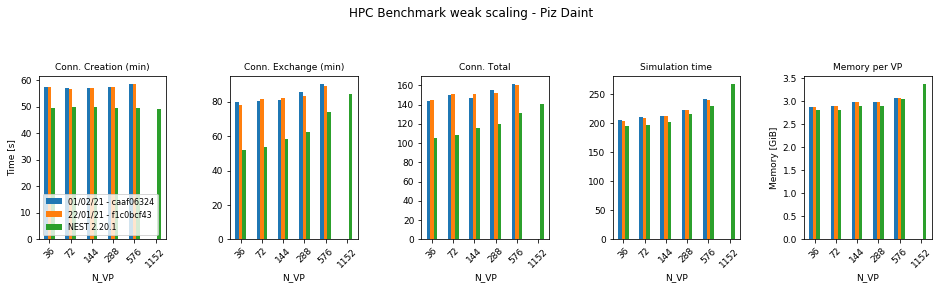

In [9]:
hpc_2201 = pd.read_csv('results/hpc_benchmark_2_20_1_daint.csv')
hpc_2201['Case'] = ['NEST 2.20.1'] * len(hpc_2201)

hpc_3_f1 = pd.read_csv('results/hpc_benchmark_3_0_f1c0bcf43_daint.csv')
hpc_3_f1['Case'] = ['22/01/21 - f1c0bcf43'] * len(hpc_3_f1)
hpc_3_ca = pd.read_csv('results/hpc_benchmark_3_0_caaf06324_daint.csv')
hpc_3_ca['Case'] = ['01/02/21 - caaf06324'] * len(hpc_3_ca)

hpc = pd.concat([hpc_2201, hpc_3_f1, hpc_3_ca])

hpc = calculate_T_conn_and_memory(hpc)
hpc_p = plot_compare(hpc, 'figures/master/hpc_benchmark_weak_scaling_daint.pdf', legend_loc='lower left',
                     title='HPC Benchmark weak scaling - Piz Daint')

hpc_p

## HPC Benchmark - strong scaling

Conn. Creation (min)                                 \
Case      01/02/21 - caaf06324 22/01/21 - f1c0bcf43 NEST 2.20   
num_tasks                                                       
6                         0.74                 0.74      0.61   
12                        0.38                 0.37      0.30   
24                        0.19                 0.19      0.15   
48                        0.10                 0.10      0.08   
96                        0.06                 0.06      0.04   
192                        NaN                  NaN      0.02   
384                        NaN                  NaN      0.01   
768                        NaN                  NaN      0.00   

          Conn. Exchange (min)                                 \
Case      01/02/21 - caaf06324 22/01/21 - f1c0bcf43 NEST 2.20   
num_tasks                                                       
6                         1.12                 1.12      0.68   
12                        0.64                 0.62      0.47   
24                        0.34                 0.35      0.31   
48                        0.31                 0.28      0.29   
96                        0.14                 0.15      0.16   
192                        NaN                  NaN      0.18   
384                        NaN                  NaN      0.20   
768                        NaN                  NaN      0.18   

                   Conn. Total                                 \
Case      01/02/21 - caaf06324 22/01/21 - f1c0bcf43 NEST 2.20   
num_tasks                                                       
6                         2.05                 2.07      1.48   
12                        1.12                 1.10      0.80   
24                        0.58                 0.59      0.49   
48                        0.44                 0.48      0.82   
96                        0.22                 0.26      0.61   
192                        NaN                  NaN      0.88   
384                        NaN                  NaN      0.94   
768                        NaN                  NaN      0.71   

               Memory per task                                 \
Case      01/02/21 - caaf06324 22/01/21 - f1c0bcf43 NEST 2.20   
num_tasks                                                       
6                     1.118997             1.086445  0.635518   
12                    1.000420             0.989515  0.540298   
24                    0.924570             0.920257  0.461600   
48                    1.111056             1.112460  0.760461   
96                    0.836211             0.836562  0.372274   
192                        NaN                  NaN  0.346288   
384                        NaN                  NaN  0.348532   
768                        NaN                  NaN  0.347982   

               Simulation time                                 
Case      01/02/21 - caaf06324 22/01/21 - f1c0bcf43 NEST 2.20  
num_tasks                                                      
6                         7.37                 7.31      6.69  
12                        4.01                 3.98      3.83  
24                        2.29                 2.43      2.42  
48                        6.31                 5.64      8.71  
96                        2.67                 2.19      2.10  
192                        NaN                  NaN      2.74  
384                        NaN                  NaN      3.36  
768                        NaN                  NaN      3.62

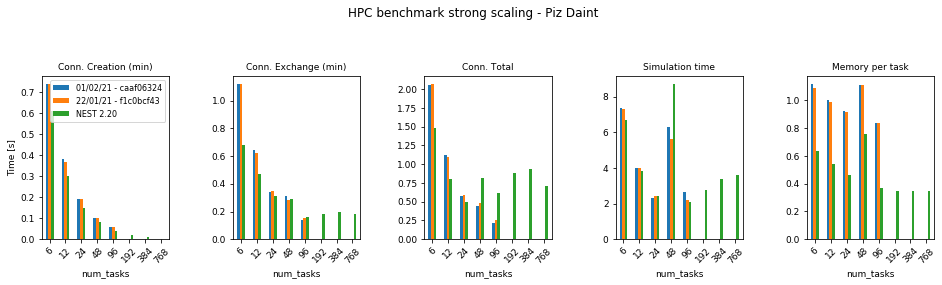

In [12]:
hpc_strong_220 = pd.read_csv('results/hpc_benchmark_2_20_daint_strong_scaling.csv')
hpc_strong_220['Case'] = ['NEST 2.20'] * len(hpc_strong_220)

hpc_strong_3_f1 = pd.read_csv('results/hpc_benchmark_3_0_f1c0bcf43_daint_strong_scaling.csv')
hpc_strong_3_f1['Case'] = ['22/01/21 - f1c0bcf43'] * len(hpc_strong_3_f1)
hpc_strong_3_ca = pd.read_csv('results/hpc_benchmark_3_0_caaf06324_daint_strong_scaling.csv')
hpc_strong_3_ca['Case'] = ['01/02/21 - caaf06324'] * len(hpc_strong_3_ca)

hpc_strong = pd.concat([hpc_strong_220, hpc_strong_3_f1, hpc_strong_3_ca])

hpc_strong = calculate_T_conn_and_memory(hpc_strong)
hpc_strong['Memory per task'] = (hpc_strong['VSize_sum']/hpc_strong['num_tasks'])*1024/1024**3

values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per task']
hpc_strong_p = plot_compare(hpc_strong, 'figures/master/hpc_benchmark_strong_scaling_daint.pdf',
                            values=values, index='num_tasks',
                            legend_loc='upper right',
                            title='HPC benchmark strong scaling - Piz Daint')

hpc_strong_p

## Population model - weak scaling

Conn. Creation (min)             Conn. Exchange (min)             \
Case 01/02/21 - caaf06324   NEST 2.20 01/02/21 - caaf06324  NEST 2.20   
N_VP                                                                    
36              40.622820   45.332983            46.986193  29.345186   
72              60.126592   80.451655            60.685587  38.265924   
144             78.148904  126.068755            63.240374  41.133215   
288            113.995589  210.201287            64.878906  48.099635   
576            188.846742  396.802894            66.013354  64.053706   
1152           336.423516  763.592566            79.392469  94.555175   

              Conn. Total                    Memory per VP            
Case 01/02/21 - caaf06324   NEST 2.20 01/02/21 - caaf06324 NEST 2.20  
N_VP                                                                  
36              97.087072   77.963455             2.319664  2.222359  
72             131.518319  122.550333             3.029583  2.927504  
144            152.550738  171.757519             3.112936  3.003872  
288            190.875659  264.531648             3.109969  2.939354  
576            267.447102  471.992790             3.110363  2.998736  
1152           435.651961  880.145318             3.111146  3.081466

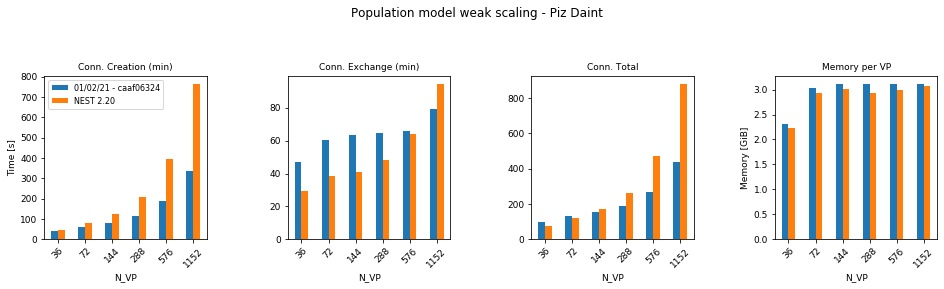

In [11]:
pop_2_20 = pd.read_csv('results/population_model_2_20_37722d5e3_daint_in_scale4.csv')
pop_2_20['Case'] = ['NEST 2.20'] * len(pop_2_20)

# pop_3_f1 = pd.read_csv('results/population_model_3_0_f1c0bcf43_daint_in.csv') # basescale = 5
# pop_3_f1['Case'] = ['22/01/21 - f1c0bcf43'] * len(pop_3_f1)
pop_3_ca = pd.read_csv('results/population_model_3_0_caaf06324_daint.csv')
pop_3_ca['Case'] = ['01/02/21 - caaf06324'] * len(pop_3_ca)

population = pd.concat([pop_2_20, pop_3_ca])

population = calculate_T_conn_and_memory(population)
population_p = plot_compare(population, 'figures/master/population_model_weak_scaling_daint.pdf',
                            plot_T_sim=False, legend_loc='upper left',
                            title='Population model weak scaling - Piz Daint')

population_p

## Population model - strong scaling

Conn. Creation (min)                                  \
Case      01/02/21 - caaf06324 22/01/21 - f1c0bcf43  NEST 2.20   
num_tasks                                                        
6                          NaN                  NaN  71.324164   
12                   75.094088            75.247277  50.129546   
24                   48.888467            48.863353  38.904915   
48                   35.660502            35.600195  33.418015   
96                   29.538110            29.528907  30.753708   
192                  26.229038            26.240525  29.517396   
384                  24.406173            24.392576  28.974048   
768                  23.213018            23.235866  27.407290   

          Conn. Exchange (min)                                  \
Case      01/02/21 - caaf06324 22/01/21 - f1c0bcf43  NEST 2.20   
num_tasks                                                        
6                          NaN                  NaN  47.624212   
12                   79.796198            75.793105  23.524206   
24                   39.136030            39.192370  12.937575   
48                   19.986350            20.397899   7.872210   
96                   10.999662            10.755967   4.671457   
192                   5.957565             5.922682   2.990739   
384                   4.368304             4.245761   1.844977   
768                   2.331345             2.350056   1.190094   

                   Conn. Total                                   \
Case      01/02/21 - caaf06324 22/01/21 - f1c0bcf43   NEST 2.20   
num_tasks                                                         
6                          NaN                  NaN  123.471093   
12                  163.407139           159.940244   76.196952   
24                   94.997510            94.955157   53.271152   
48                   59.317371            59.795954   42.225837   
96                   42.529820            42.282152   36.140110   
192                  33.524474            33.679288   33.340712   
384                  29.900469            29.785677   31.634172   
768                  26.654113            26.689058   29.502074   

               Memory per task                                  
Case      01/02/21 - caaf06324 22/01/21 - f1c0bcf43  NEST 2.20  
num_tasks                                                       
6                          NaN                  NaN  20.938893  
12                   21.826507            21.826507  11.013250  
24                   12.266468            12.292509   6.395530  
48                    7.221660             7.213848   3.788223  
96                    4.697091             4.697091   2.483136  
192                   3.623420             3.623624   1.937623  
384                   2.924017             2.926571   1.605255  
768                   2.422199             2.421286   1.349469

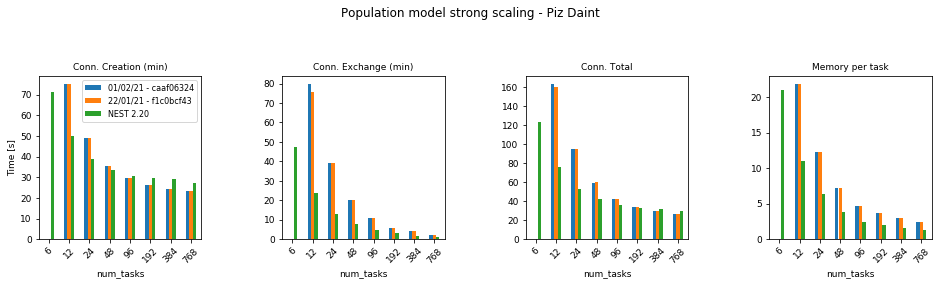

In [16]:
pop_strong_220 = pd.read_csv('results/population_model_2_20_daint_strong_scaling_in.csv')
pop_strong_220['Case'] = ['NEST 2.20'] * len(pop_strong_220)

pop_strong_3_f1 = pd.read_csv('results/population_model_3_0_f1c0bcf43_daint_strong_scaling.csv')
pop_strong_3_f1['Case'] = ['22/01/21 - f1c0bcf43'] * len(pop_strong_3_f1)
pop_strong_3_ca = pd.read_csv('results/population_model_3_0_caaf06324_daint_strong_scaling.csv')
pop_strong_3_ca['Case'] = ['01/02/21 - caaf06324'] * len(pop_strong_3_ca)

pop_strong = pd.concat([pop_strong_220, pop_strong_3_f1, pop_strong_3_ca])

pop_strong = calculate_T_conn_and_memory(pop_strong)
pop_strong['Memory per task'] = (pop_strong['VSize_sum']/pop_strong['num_tasks'])*1024/1024**3

values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per task']
pop_strong_p = plot_compare(pop_strong, 'figures/master/population_model_strong_scaling_daint.pdf',
                            values=values, index='num_tasks',
                            legend_loc='upper right', plot_T_sim=False,
                            title='Population model strong scaling - Piz Daint')

pop_strong_p

## Multi-Area Model - weak scaling

Conn. Creation (min)                                    \
Case 01/02/21 - caaf06324 22/01/21 - f1c0bcf43    NEST 2.20   
N_VP                                                          
36              85.155642            82.053930   101.140661   
72              88.451504            87.234036   142.670350   
144             90.584632            92.462281   219.767402   
288             97.242817            96.973146   375.065322   
576            107.675847           102.441367   681.150122   
1152           123.735972           124.937030  1345.261425   

     Conn. Exchange (min)                                  \
Case 01/02/21 - caaf06324 22/01/21 - f1c0bcf43  NEST 2.20   
N_VP                                                        
36              51.528593            52.442780  36.570883   
72              55.906681            52.876590  39.116908   
144             53.544582            53.623115  42.355595   
288             55.109672            55.353996  48.209567   
576             57.848789            57.323001  46.179023   
1152            59.510680            59.942349  79.810095   

              Conn. Total                                    \
Case 01/02/21 - caaf06324 22/01/21 - f1c0bcf43    NEST 2.20   
N_VP                                                          
36             136.684361           134.496826   137.711928   
72             144.359141           140.110780   181.787644   
144            144.129375           146.085584   262.123474   
288            152.352916           152.327618   423.275385   
576            165.526469           159.764709   727.330681   
1152           183.249203           184.880362  1425.072861   

            Memory per VP                                     Simulation time  \
Case 01/02/21 - caaf06324 22/01/21 - f1c0bcf43 NEST 2.20 01/02/21 - caaf06324   
N_VP                                                                            
36               2.663070             2.664698  2.617272           594.216136   
72               2.738522             2.740177  2.667822           643.042684   
144              2.801340             2.803443  2.720535           304.222491   
288              2.902135             2.897924  2.900764           193.938503   
576              2.718729             2.719489  2.782890           257.265700   
1152             2.958394             2.968078  3.462652           404.681445   

                                        
Case 22/01/21 - f1c0bcf43    NEST 2.20  
N_VP                                    
36             610.229675  1042.972012  
72             622.808127  1292.922784  
144            303.254718  1556.467327  
288            176.950068  1944.559042  
576            244.308482    57.701872  
1152           316.249295  3309.601989

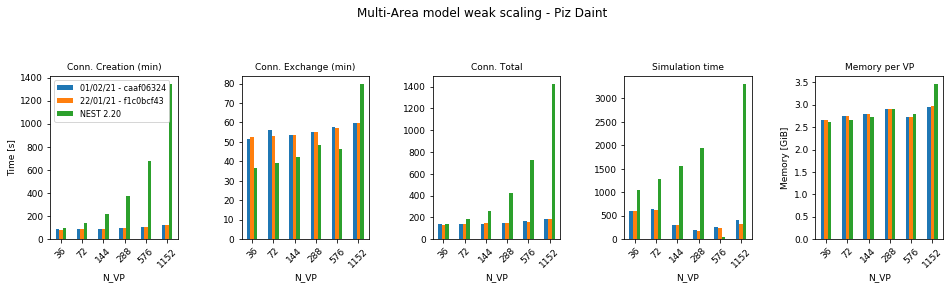

In [10]:
MAM_220 = pd.read_csv('results/multi-area_model_2_20_daint.csv')
MAM_220['Case'] = ['NEST 2.20'] * len(MAM_220)

MAM_f1 = pd.read_csv('results/multi-area_model_3_f1c0bcf43_daint.csv')
MAM_f1['Case'] = ['22/01/21 - f1c0bcf43'] * len(MAM_f1)
MAM_ca = pd.read_csv('results/multi-area_model_3_caaf06324_daint.csv')
MAM_ca['Case'] = ['01/02/21 - caaf06324'] * len(MAM_ca)

MAM = pd.concat([MAM_220, MAM_f1, MAM_ca])

MAM['T_conns_min'] = MAM['T_network_global_min'] + MAM['T_connect_min']
MAM['T_conns_max'] = MAM['T_network_global_max'] + MAM['T_connect_max']

MAM = calculate_T_conn_and_memory(MAM)
MAM_p = plot_compare(MAM, 'figures/master/multi-area_model_weak_scaling_daint.pdf', legend_loc='upper left',
                     title='Multi-Area model weak scaling - Piz Daint')
MAM_p

## Multi-Area model - strong scaling

Conn. Creation (min)                                   \
Case      01/02/21 - caaf06324 22/01/21 - f1c0bcf43   NEST 2.20   
num_tasks                                                         
192                  72.873003            76.236485  656.739572   
288                  66.617286            65.244569  647.955257   
384                        NaN            64.594181         NaN   
480                        NaN                  NaN  642.865273   
576                  59.061144            59.014024  642.099864   
672                  58.321373                  NaN  640.462307   
768                  58.264421                  NaN  640.647660   

          Conn. Exchange (min)                                  \
Case      01/02/21 - caaf06324 22/01/21 - f1c0bcf43  NEST 2.20   
num_tasks                                                        
192                  30.636053            30.393209  27.460267   
288                  22.073771            21.910562  21.280975   
384                        NaN            17.654079        NaN   
480                        NaN                  NaN  15.629361   
576                  16.504207            13.338382  13.862626   
672                  13.234139                  NaN  12.313328   
768                  12.532195                  NaN  11.422459   

                   Conn. Total                                   \
Case      01/02/21 - caaf06324 22/01/21 - f1c0bcf43   NEST 2.20   
num_tasks                                                         
192                 103.510236           106.629971  684.200660   
288                  88.691417            87.155586  669.237295   
384                        NaN            82.248577         NaN   
480                        NaN                  NaN  658.496879   
576                  75.567345            72.357951  655.966974   
672                  71.560800                  NaN  652.782241   
768                  70.799140                  NaN  652.083801   

               Memory per task                                  \
Case      01/02/21 - caaf06324 22/01/21 - f1c0bcf43  NEST 2.20   
num_tasks                                                        
192                  10.340675            10.337420  10.806041   
288                   7.338802             7.339345   7.684051   
384                        NaN             6.399700        NaN   
480                        NaN                  NaN   5.874357   
576                   5.145900             5.145727   5.298488   
672                   4.757384                  NaN   4.921475   
768                   4.473858                  NaN   4.536059   

               Simulation time                                   
Case      01/02/21 - caaf06324 22/01/21 - f1c0bcf43   NEST 2.20  
num_tasks                                                        
192                 174.418188           179.673470  149.841436  
288                 201.468596           236.386435  202.562903  
384                        NaN           202.463715         NaN  
480                        NaN                  NaN  216.793543  
576                 176.377344           179.221840  183.220357  
672                 224.446313                  NaN  209.088735  
768                 198.862505                  NaN  183.525031

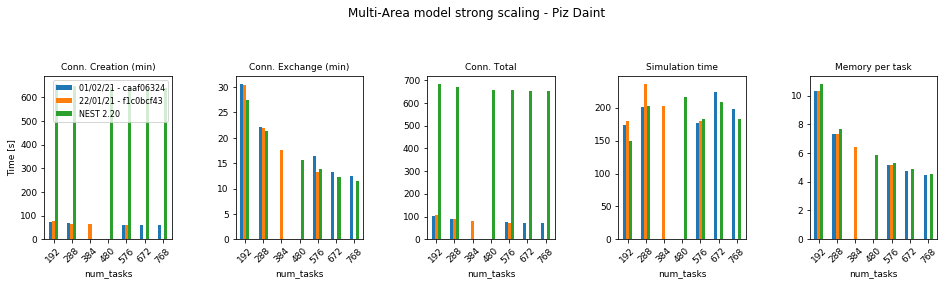

In [14]:
MAM_strong_220 = pd.read_csv('results/multi-area_model_2_20_daint_strong_scaling.csv')
MAM_strong_220['Case'] = ['NEST 2.20'] * len(MAM_strong_220)

MAM_strong_3_f1 = pd.read_csv('results/multi-area_model_3_f1c0bcf43_daint_strong_scaling.csv')
MAM_strong_3_f1['Case'] = ['22/01/21 - f1c0bcf43'] * len(MAM_strong_3_f1)
MAM_strong_3_ca = pd.read_csv('results/multi-area_model_3_0_caaf06324_daint_strong_scaling.csv')
MAM_strong_3_ca['Case'] = ['01/02/21 - caaf06324'] * len(MAM_strong_3_ca)

MAM_strong = pd.concat([MAM_strong_220, MAM_strong_3_f1, MAM_strong_3_ca])

MAM_strong = calculate_T_conn_and_memory(MAM_strong)
MAM_strong['Memory per task'] = (MAM_strong['VSize_sum']/MAM_strong['num_tasks'])*1024/1024**3

values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per task']
MAM_strong_p = plot_compare(MAM_strong, 'figures/master/multi-area_model_strong_scaling_daint.pdf',
                            values=values, index='num_tasks',
                            legend_loc='upper right',
                            title='Multi-Area model strong scaling - Piz Daint')

MAM_strong_p

## Hill Tononi benchmark - strong scaling

Conn. Creation (min)                                 \
Case      01/02/21 - caaf06324 22/01/21 - f1c0bcf43 NEST 2.20   
num_tasks                                                       
6                     0.540016             0.539793  3.369209   
12                    0.341684             0.341052  2.424937   
24                    0.234824             0.235468  1.863762   
48                         NaN                  NaN  1.672143   
96                         NaN                  NaN  1.589094   
192                   0.115680             0.114033  3.329755   
384                   0.101525             0.099252  1.560687   
768                   0.094390             0.095244  3.677774   

          Conn. Exchange (min)                                 \
Case      01/02/21 - caaf06324 22/01/21 - f1c0bcf43 NEST 2.20   
num_tasks                                                       
6                     0.374554             0.374104  0.344653   
12                    0.419666             0.418206  0.328508   
24                    0.329793             0.335053  0.278032   
48                         NaN                  NaN  0.188323   
96                         NaN                  NaN  0.149609   
192                   0.181406             0.190046  0.116746   
384                   0.233559             0.225399  0.129887   
768                   0.299747             0.358355  0.185456   

                   Conn. Total                                 \
Case      01/02/21 - caaf06324 22/01/21 - f1c0bcf43 NEST 2.20   
num_tasks                                                       
6                     0.967777             0.950275  3.853066   
12                    0.784930             0.949178  2.901895   
24                    0.587285             0.675131  2.281637   
48                         NaN                  NaN  2.019383   
96                         NaN                  NaN  1.900187   
192                   0.349877             0.451414  3.600970   
384                   0.423277             0.496812  1.859231   
768                   0.566913             0.627140  4.055079   

               Memory per task                                 \
Case      01/02/21 - caaf06324 22/01/21 - f1c0bcf43 NEST 2.20   
num_tasks                                                       
6                     1.970375             1.976885  1.346101   
12                    1.938468             1.931388  1.298610   
24                    1.893909             1.887968  1.256289   
48                         NaN                  NaN  1.120590   
96                         NaN                  NaN  1.015988   
192                   1.685396             1.685554  1.013022   
384                   1.709280             1.705924  1.042091   
768                   1.708483             1.708520  1.038055   

               Simulation time                                 
Case      01/02/21 - caaf06324 22/01/21 - f1c0bcf43 NEST 2.20  
num_tasks                                                      
6                     1.332822             1.333143  1.442217  
12                    0.815106             0.794388  0.866928  
24                    0.583303             0.562665  0.613624  
48                         NaN                  NaN  0.398614  
96                         NaN                  NaN  0.357492  
192                   0.353341             0.450616  0.308830  
384                   0.334949             0.560679  0.286875  
768                   0.474522             0.581242  0.325538

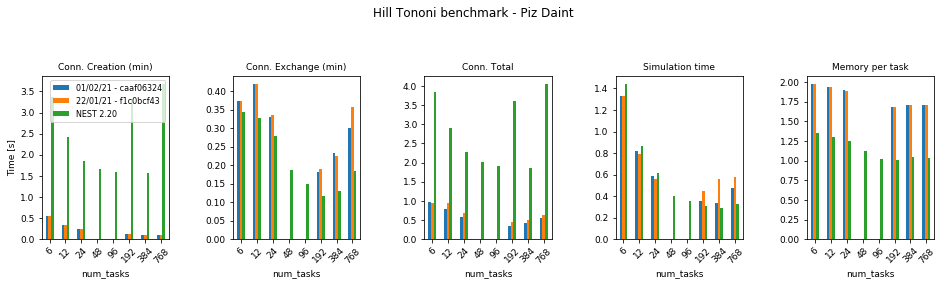

In [15]:
hill_tononi_220 = pd.read_csv('results/hill_tononi_2_20_daint.csv')
hill_tononi_220['Case'] = ['NEST 2.20'] * len(hill_tononi_220)

hill_tononi_3 = pd.read_csv('results/hill_tononi_3_0_f1c0bcf43_daint.csv')
hill_tononi_3['Case'] = ['22/01/21 - f1c0bcf43'] * len(hill_tononi_3)
hill_tononi_3_ca = pd.read_csv('results/hill_tononi_3_0_caaf06324_daint.csv')
hill_tononi_3_ca['Case'] = ['01/02/21 - caaf06324'] * len(hill_tononi_3_ca)

hill_tononi = pd.concat([hill_tononi_220, hill_tononi_3, hill_tononi_3_ca])

hill_tononi = calculate_T_conn_and_memory(hill_tononi)
hill_tononi['Memory per task'] = (hill_tononi['VSize_sum']/hill_tononi['num_tasks'])*1024/1024**3

values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per task']
hill_tononi_p = plot_compare(hill_tononi, 'figures/master/hill_tononi_strong_scaling_daint.pdf', values=values,
                             index='num_tasks', legend_loc='upper right',
                             title='Hill Tononi benchmark - Piz Daint')

hill_tononi_p

# Benchmarks - JUSUF

## HPC Benchmark - weak scaling

Conn. Creation (min)             Conn. Exchange (min)              \
Case 22/01/21 - f1c0bcf43 NEST 2.20.1 22/01/21 - f1c0bcf43 NEST 2.20.1   
N_VP                                                                     
36                  24.79       21.60                49.72       41.28   
72                  22.70       21.84                52.41       41.94   
144                 22.09       21.42                61.24       44.11   
288                 22.84       21.14                59.03       47.06   
576                 22.22       21.14                71.04       73.57   
1152                22.95       21.13                75.65       82.24   

              Conn. Total                    Memory per VP              \
Case 22/01/21 - f1c0bcf43 NEST 2.20.1 22/01/21 - f1c0bcf43 NEST 2.20.1   
N_VP                                                                     
36                  91.45       93.95             2.843979    2.851386   
72                 108.92       92.09             2.844088    2.851441   
144                122.14       97.77             2.914509    2.925307   
288                125.29      103.31             2.933471    2.940755   
576                134.69      131.52             2.974389    3.013948   
1152               141.42      142.66             3.396348    3.412535   

          Simulation time              
Case 22/01/21 - f1c0bcf43 NEST 2.20.1  
N_VP                                   
36                 169.67      139.24  
72                 139.30      209.83  
144                229.10      227.65  
288                234.83      247.49  
576                345.54      321.37  
1152               353.68      391.60

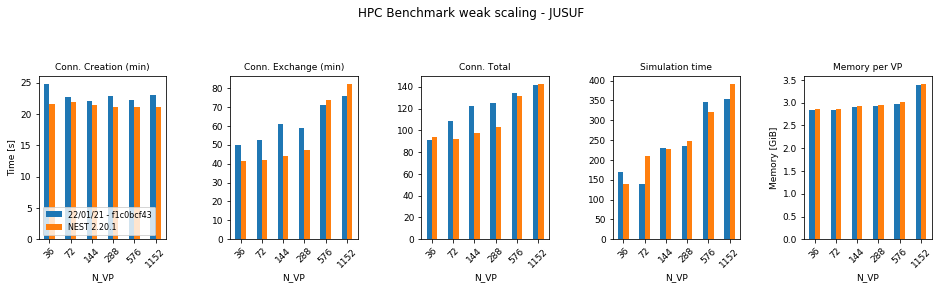

In [30]:
hpc_2201_j = pd.read_csv('results/jusuf/hpc_benchmark_2_20_1_jusuf.csv')
hpc_2201_j['Case'] = ['NEST 2.20.1'] * len(hpc_2201_j)

hpc_3_f1_j = pd.read_csv('results/jusuf/hpc_benchmark_3_0_f1c0bcf_jusuf.csv')
hpc_3_f1_j['Case'] = ['22/01/21 - f1c0bcf43'] * len(hpc_3_f1_j)

hpc_j = pd.concat([hpc_2201_j, hpc_3_f1_j])

hpc_j = calculate_T_conn_and_memory(hpc_j)
hpc_p_j = plot_compare(hpc_j, 'figures/master/hpc_benchmark_weak_scaling_jusuf.pdf', legend_loc='lower left',
                       title='HPC Benchmark weak scaling - JUSUF')

hpc_p_j

## Population model - weak scaling

Conn. Creation (min)             Conn. Exchange (min)              \
Case 22/01/21 - f1c0bcf43 NEST 2.20.1 22/01/21 - f1c0bcf43 NEST 2.20.1   
N_VP                                                                     
36              26.481560   34.586005            49.737605   28.871291   
72              31.355853   46.916655            44.627181   42.912707   
144             39.771137   71.252512            55.771053   47.267053   
288             57.414136  121.550554            54.698159   47.831871   
576             93.151953  219.210398            62.549602   52.124004   
1152           164.549907  424.698878            86.195792   78.156629   

              Conn. Total                     Memory per VP              
Case 22/01/21 - f1c0bcf43  NEST 2.20.1 22/01/21 - f1c0bcf43 NEST 2.20.1  
N_VP                                                                     
36             121.613727    90.211290             3.447903    3.439235  
72             135.026989   181.386278             3.502307    3.468906  
144            173.067175   258.406246             3.658665    3.612121  
288            217.794071   406.491713             3.507420    3.504879  
576            359.155050   723.118357             3.517559    3.560418  
1152           585.761179  1375.119033             3.940674    3.740453

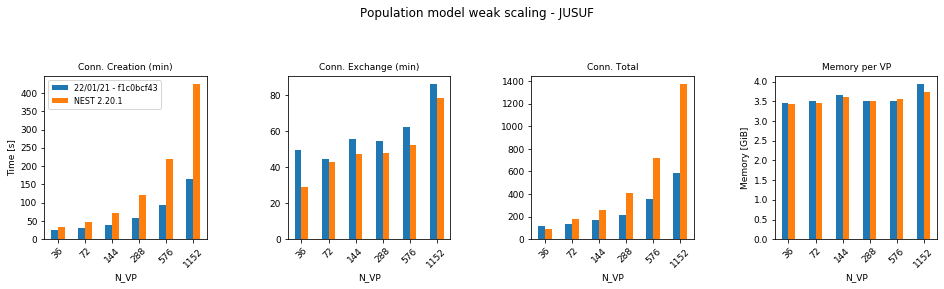

In [40]:
pop_2_20_1_j = pd.read_csv('results/jusuf/population_model_2_20_1_jusuf.csv')
pop_2_20_1_j['Case'] = ['NEST 2.20.1'] * len(pop_2_20_1_j)

pop_3_f1_j = pd.read_csv('results/jusuf/population_model_3_0_f1c0bcf_jusuf.csv')
pop_3_f1_j['Case'] = ['22/01/21 - f1c0bcf43'] * len(pop_3_f1_j)

population_j = pd.concat([pop_2_20_1_j, pop_3_f1_j])

population_j = calculate_T_conn_and_memory(population_j)
population_p_j = plot_compare(population_j, 'figures/master/population_model_weak_scaling_jusuf.pdf',
                              plot_T_sim=False, legend_loc='upper left',
                              title='Population model weak scaling - JUSUF')

population_p_j

## Multi-Area Model - weak scaling

Conn. Creation (min)             Conn. Exchange (min)              \
Case 22/01/21 - f1c0bcf43 NEST 2.20.1 22/01/21 - f1c0bcf43 NEST 2.20.1   
N_VP                                                                     
36              44.513203   58.028205            27.282612   25.800741   
72              41.715904   67.998503            30.936866   19.707447   
144             28.974241  103.005810            40.520248   27.587769   
288             26.277907  171.405990             4.000000   30.271936   
576             24.341670  312.493823            55.598614   38.298826   
1152            26.544310  612.651893             6.000000   54.534787   

              Conn. Total                    Memory per VP              \
Case 22/01/21 - f1c0bcf43 NEST 2.20.1 22/01/21 - f1c0bcf43 NEST 2.20.1   
N_VP                                                                     
36           7.180307e+01   83.830068             2.491653    2.490952   
72           7.265807e+01   87.707513             2.518561    2.534414   
144          6.950631e+01  130.596112             2.607013    2.584296   
288          6.984486e+01  201.684071             2.727979    2.760934   
576          7.995847e+01  350.800892             2.570250    2.661718   
1152         4.606922e+08  667.195099             2.897639    3.195032   

          Simulation time               
Case 22/01/21 - f1c0bcf43  NEST 2.20.1  
N_VP                                    
36             483.899982   431.568564  
72             455.186623   521.614744  
144           1057.060788   709.615256  
288            704.385814  1729.604418  
576           2752.079966  1911.423645  
1152          4638.169469  3994.607314

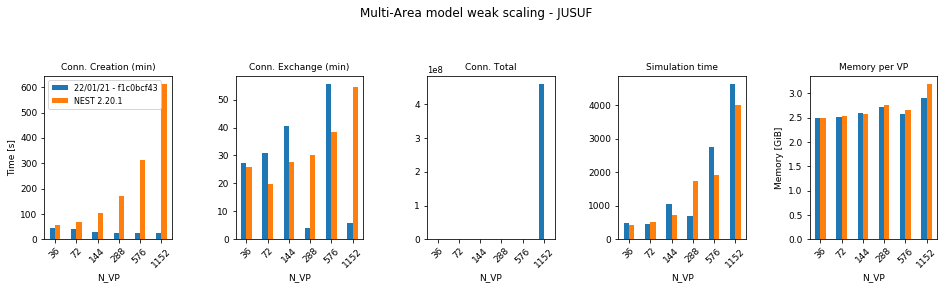

In [39]:
MAM_2201_j = pd.read_csv('results/jusuf/multi-area_model_2_20_1_jusuf.csv')
MAM_2201_j['Case'] = ['NEST 2.20.1'] * len(MAM_2201_j)

MAM_f1_j = pd.read_csv('results/jusuf/multi-area_model_3_0_f1c0bcf_jusuf.csv')
MAM_f1_j['Case'] = ['22/01/21 - f1c0bcf43'] * len(MAM_f1_j)

MAM_j = pd.concat([MAM_2201_j, MAM_f1_j])

MAM_j['T_conns_min'] = MAM_j['T_network_global_min'] + MAM_j['T_connect_min']
MAM_j['T_conns_max'] = MAM_j['T_network_global_max'] + MAM_j['T_connect_max']

MAM_j = calculate_T_conn_and_memory(MAM_j)
MAM_p_j = plot_compare(MAM_j, 'figures/master/multi-area_model_weak_scaling_jusuf.pdf', legend_loc='upper left',
                       title='Multi-Area model weak scaling - JUSUF')
MAM_p_j 

## Multi-Area model - strong scaling

Conn. Creation (min)             Conn. Exchange (min)              \
Case      22/01/21 - f1c0bcf43 NEST 2.20.1 22/01/21 - f1c0bcf43 NEST 2.20.1   
num_tasks                                                                     
192                  38.661782         NaN            46.433619         NaN   
288                  34.893286  294.011901            41.410000   37.751946   
384                  33.496387  292.624491            38.529833   37.260971   
480                  32.917373         NaN            38.140000         NaN   

                   Conn. Total                  Memory per task              \
Case      22/01/21 - f1c0bcf43 NEST 2.20.1 22/01/21 - f1c0bcf43 NEST 2.20.1   
num_tasks                                                                     
192                  85.107943         NaN             9.606937         NaN   
288                  76.320634  331.783264             6.603925    7.141737   
384                  72.044919  329.909772             5.722342    6.171266   
480                  71.081389         NaN             5.031285         NaN   

               Simulation time               
Case      22/01/21 - f1c0bcf43  NEST 2.20.1  
num_tasks                                    
192                4129.064691          NaN  
288                3953.518658  3842.288482  
384                4382.156696  3575.848351  
480                4364.946366          NaN

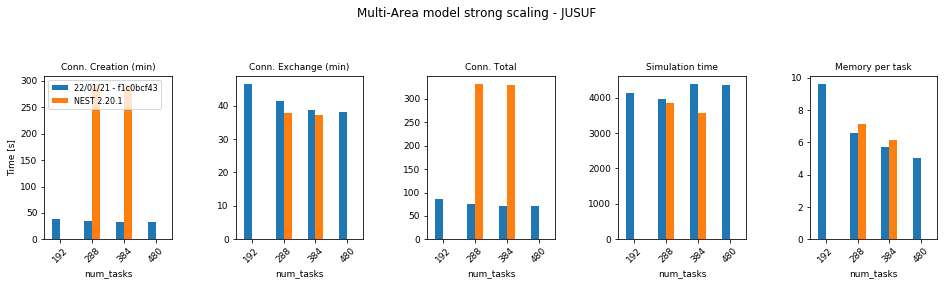

In [15]:
MAM_s_2201_j = pd.read_csv('results/jusuf/multi-area_model_2_20_1_jusuf_strong.csv')
MAM_s_2201_j['Case'] = ['NEST 2.20.1'] * len(MAM_s_2201_j)

MAM_s_3_f1_j = pd.read_csv('results/jusuf/multi-area_model_3_0_f1c0bcf_jusuf_strong.csv')
MAM_s_3_f1_j['Case'] = ['22/01/21 - f1c0bcf43'] * len(MAM_s_3_f1_j)

MAM_strong_j = pd.concat([MAM_s_2201_j, MAM_s_3_f1_j])

MAM_strong_j = calculate_T_conn_and_memory(MAM_strong_j)
MAM_strong_j['Memory per task'] = (MAM_strong_j['VSize_sum']/MAM_strong_j['num_tasks'])*1024/1024**3

values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per task']
MAM_strong_p_j = plot_compare(MAM_strong_j, 'figures/master/multi-area_model_strong_scaling_jusuf.pdf',
                              values=values,
                              index='num_tasks', legend_loc='upper left',
                              title='Multi-Area model strong scaling - JUSUF')

MAM_strong_p_j

## Hill-Tononi - strong scaling

Conn. Creation (min)             Conn. Exchange (min)              \
Case      22/01/21 - f1c0bcf43 NEST 2.20.1 22/01/21 - f1c0bcf43 NEST 2.20.1   
num_tasks                                                                     
6                     0.359311    3.766484             0.576593    0.481786   
12                    0.229506    2.501482             1.339874    1.468281   
24                    0.110095         NaN             1.471378         NaN   
48                    0.094700    1.815122             1.986401    2.165154   
96                    0.069702    1.472585             1.991013    2.094121   
192                   0.063093    1.522467             1.327950    1.248941   
384                   0.057447    1.617119             3.224848    3.132705   

                   Conn. Total                  Memory per task              \
Case      22/01/21 - f1c0bcf43 NEST 2.20.1 22/01/21 - f1c0bcf43 NEST 2.20.1   
num_tasks                                                                     
6                     1.393004    4.286162             1.005372    0.939561   
12                    1.847409    4.008401             0.997564    0.950850   
24                    1.807954         NaN             0.966965         NaN   
48                    2.266833    4.086685             1.010096    0.919352   
96                    2.234218    3.726906             1.017278    0.929611   
192                   1.576280    2.885911             0.969180    0.917815   
384                   3.470688    4.838200             1.018986    0.976752   

               Simulation time              
Case      22/01/21 - f1c0bcf43 NEST 2.20.1  
num_tasks                                   
6                     3.909697    4.086648  
12                    5.657288    7.490199  
24                    8.035491         NaN  
48                   15.447431   18.072147  
96                   23.831436   23.599114  
192                   2.015620    1.960254  
384                   2.074166    2.075324

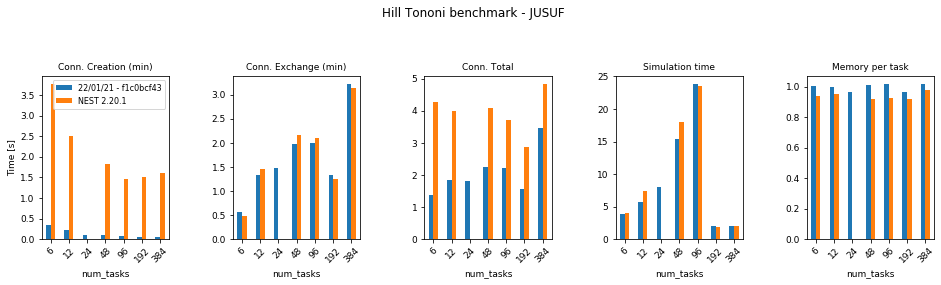

In [19]:
ht_2201_j = pd.read_csv('results/jusuf/hill_tononi_2_20_1_jusuf.csv')
ht_2201_j['Case'] = ['NEST 2.20.1'] * len(ht_2201_j)

ht_3_f1_j = pd.read_csv('results/jusuf/hill_tononi_3_0_f1c0bcf43_jusuf.csv')
ht_3_f1_j['Case'] = ['22/01/21 - f1c0bcf43'] * len(ht_3_f1_j)

hill_tononi_j = pd.concat([ht_2201_j, ht_3_f1_j])

hill_tononi_j = calculate_T_conn_and_memory(hill_tononi_j)
hill_tononi_j['Memory per task'] = (hill_tononi_j['VSize_sum']/hill_tononi_j['num_tasks'])*1024/1024**3

values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per task']
hill_tononi_p_j = plot_compare(hill_tononi_j, 'figures/master/hill_tononi_strong_scaling_jusuf.pdf', values=values,
                               index='num_tasks', legend_loc='upper right',
                               title='Hill Tononi benchmark - JUSUF')

hill_tononi_p_j